# Installation

In [1]:
!pip install -U scikit-learn imbalanced-learn


[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# Code

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import lightgbm as lgb

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_botnet = pd.read_parquet('Dataset/Botnet-Friday-02-03-2018_TrafficForML_CICFlowMeter.parquet')
df_bruteforce = pd.read_parquet('Dataset/Bruteforce-Wednesday-14-02-2018_TrafficForML_CICFlowMeter.parquet')
df_ddos1 = pd.read_parquet('Dataset/DDoS1-Tuesday-20-02-2018_TrafficForML_CICFlowMeter.parquet')
df_ddos2 = pd.read_parquet('Dataset/DDoS2-Wednesday-21-02-2018_TrafficForML_CICFlowMeter.parquet')
df_dos1 = pd.read_parquet('Dataset/DoS1-Thursday-15-02-2018_TrafficForML_CICFlowMeter.parquet')
df_dos2 = pd.read_parquet('Dataset/DoS2-Friday-16-02-2018_TrafficForML_CICFlowMeter.parquet')
df_infil1 = pd.read_parquet('Dataset/Infil1-Wednesday-28-02-2018_TrafficForML_CICFlowMeter.parquet')
df_infil2 = pd.read_parquet('Dataset/Infil2-Thursday-01-03-2018_TrafficForML_CICFlowMeter.parquet')
df_web1 = pd.read_parquet('Dataset/Web1-Thursday-22-02-2018_TrafficForML_CICFlowMeter.parquet')
df_web2 = pd.read_parquet('Dataset/Web2-Friday-23-02-2018_TrafficForML_CICFlowMeter.parquet')

In [3]:
df_botnet.head(10)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,141385,9,7,553,3773.0,202,0,61.444443,87.534439,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,6,281,2,1,38,0.0,38,0,19.000000,26.870058,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,6,279824,11,15,1086,10527.0,385,0,98.727272,129.392502,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,6,132,2,0,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,6,274016,9,13,1285,6141.0,517,0,142.777771,183.887726,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
5,6,250,2,0,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
6,6,5964033,3,1,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
7,6,144,2,0,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
8,6,90828,8,8,1748,3898.0,1078,0,218.500000,363.713379,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
9,6,152,3,0,31,0.0,31,0,10.333333,17.897858,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [3]:
dfs = {
    'botnet': df_botnet,
    'bruteforce': df_bruteforce,
    'ddos1': df_ddos1,
    'ddos2': df_ddos2,
    'dos1': df_dos1,
    'dos2': df_dos2,
    'infil1': df_infil1,
    'infil2': df_infil2,
    'web1': df_web1,
    'web2': df_web2
}

for name, df in dfs.items():
    print(f"Value Count for {name}")
    print(df["Label"].value_counts())
    print("\n")

Value Count for botnet
Label
Benign    627052
Bot       144535
Name: count, dtype: int64


Value Count for bruteforce
Label
Benign            525245
SSH-Bruteforce     94048
FTP-BruteForce        53
Name: count, dtype: int64


Value Count for ddos1
Label
DDoS attacks-LOIC-HTTP    575364
Benign                    379482
Name: count, dtype: int64


Value Count for ddos2
Label
Benign                  360805
DDOS attack-HOIC        198861
DDOS attack-LOIC-UDP      1730
Name: count, dtype: int64


Value Count for dos1
Label
Benign                   743498
DoS attacks-GoldenEye     41406
DoS attacks-Slowloris      9908
Name: count, dtype: int64


Value Count for dos2
Label
Benign                      446619
DoS attacks-Hulk            145199
DoS attacks-SlowHTTPTest        55
Name: count, dtype: int64


Value Count for infil1
Label
Benign           400424
Infilteration     56449
Name: count, dtype: int64


Value Count for infil2
Label
Benign           187136
Infilteration     62034
Name: cou

In [4]:
df_botnet.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [5]:
df_web2['Protocol'].value_counts()

Protocol
6     604746
17    208936
0      15723
Name: count, dtype: int64

In [6]:
protocol_map = {6: 'TCP', 17: 'UDP'}
for name,df in dfs.items():
    df['ProtocolName'] = df['Protocol'].map(protocol_map).fillna('Other')

In [8]:
df_web2['ProtocolName'].unique()

array(['TCP', 'UDP', 'Other'], dtype=object)

In [7]:
df_all = pd.concat(dfs.values(),ignore_index=True)

In [10]:
print(df_all.shape)
print(df_all['Label'].value_counts())

(6659532, 79)
Label
Benign                      5329008
DDoS attacks-LOIC-HTTP       575364
DDOS attack-HOIC             198861
DoS attacks-Hulk             145199
Bot                          144535
Infilteration                118483
SSH-Bruteforce                94048
DoS attacks-GoldenEye         41406
DoS attacks-Slowloris          9908
DDOS attack-LOIC-UDP           1730
Brute Force -Web                568
Brute Force -XSS                229
SQL Injection                    85
DoS attacks-SlowHTTPTest         55
FTP-BruteForce                   53
Name: count, dtype: int64


In [11]:
df_all.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [8]:
cols = list(df_all.columns)
cols.remove('ProtocolName')
idx = cols.index('Protocol')
cols.insert(idx + 1, 'ProtocolName')
df_all = df_all[cols]

In [9]:
df_all.head()

,Protocol,ProtocolName,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,6,TCP,141385,9,7,553,3773.0,202,0,61.444443,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,6,TCP,281,2,1,38,0.0,38,0,19.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,6,TCP,279824,11,15,1086,10527.0,385,0,98.727272,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,6,TCP,132,2,0,0,0.0,0,0,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,6,TCP,274016,9,13,1285,6141.0,517,0,142.777771,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


# EDA

In [14]:
df_all['Label'].value_counts()

Label
Benign                      5329008
DDoS attacks-LOIC-HTTP       575364
DDOS attack-HOIC             198861
DoS attacks-Hulk             145199
Bot                          144535
Infilteration                118483
SSH-Bruteforce                94048
DoS attacks-GoldenEye         41406
DoS attacks-Slowloris          9908
DDOS attack-LOIC-UDP           1730
Brute Force -Web                568
Brute Force -XSS                229
SQL Injection                    85
DoS attacks-SlowHTTPTest         55
FTP-BruteForce                   53
Name: count, dtype: int64

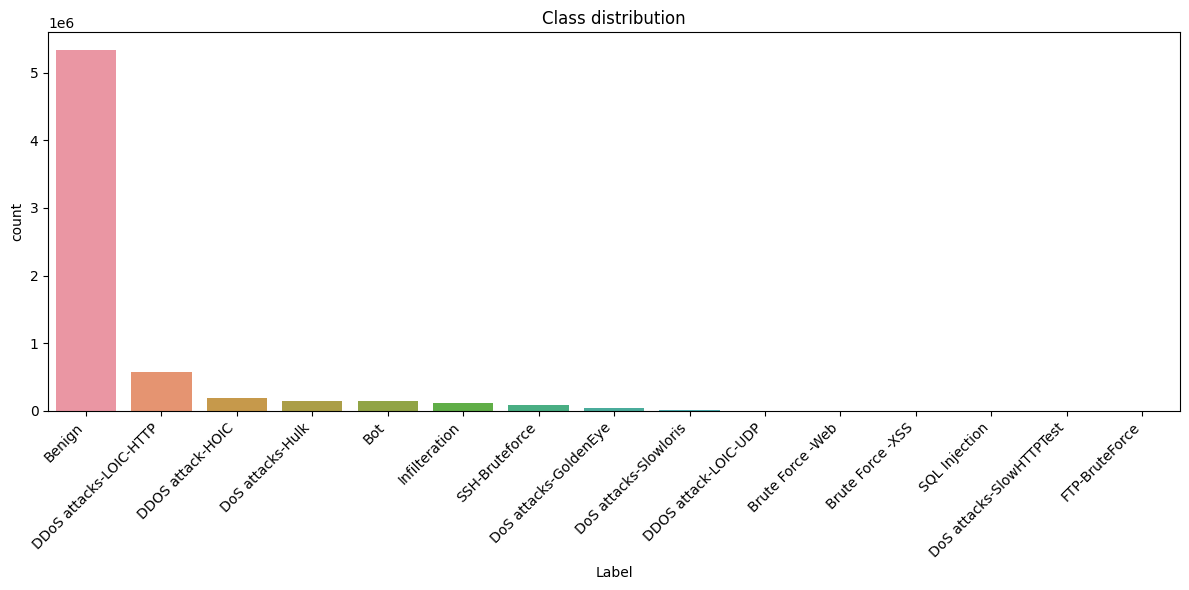

In [15]:
order = df_all['Label'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(12,6))
sns.countplot(data=df_all, x='Label', order=order)
plt.xticks(rotation=45, ha='right')
plt.title('Class distribution')
plt.tight_layout()
plt.show()

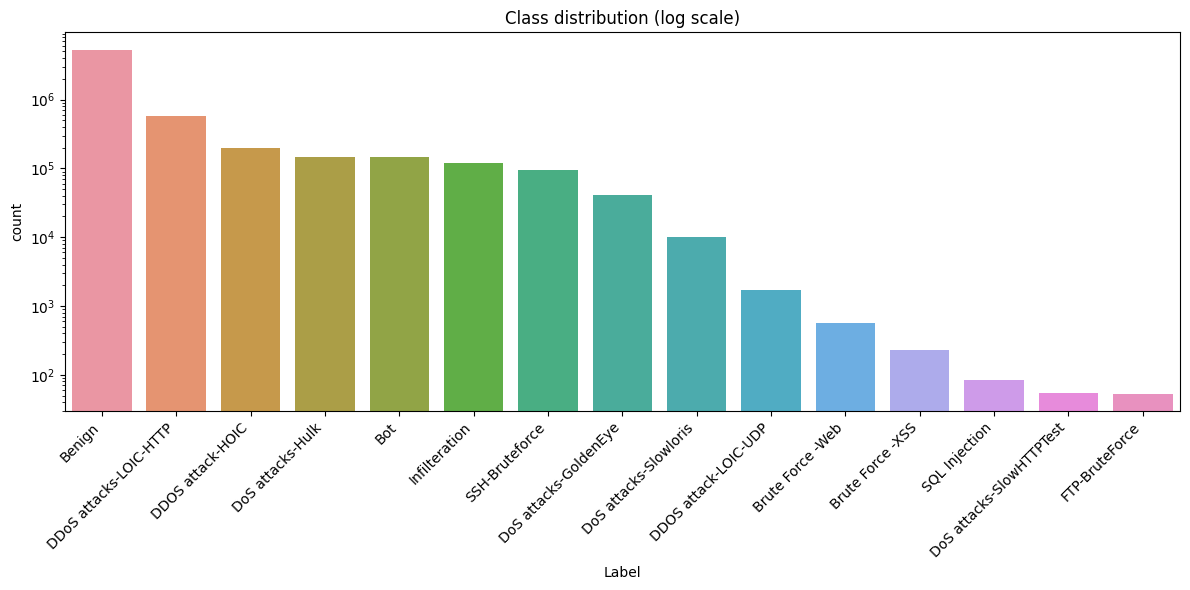

In [16]:
order = df_all['Label'].value_counts().sort_values(ascending=False).index

plt.figure(figsize=(12,6))
sns.countplot(data=df_all, x='Label', order=order)
plt.yscale('log')
plt.xticks(rotation=45, ha='right')
plt.title('Class distribution (log scale)')
plt.tight_layout()
plt.show()

### The dataset is highly imbalanced, with the "Benign" class representing the vast majority of samples. Each attack type is much less frequent, and some attacks are particularly rare. This class imbalance must be taken into account during model training and evaluation, as it can bias the results and hinder the detection of minority classes.

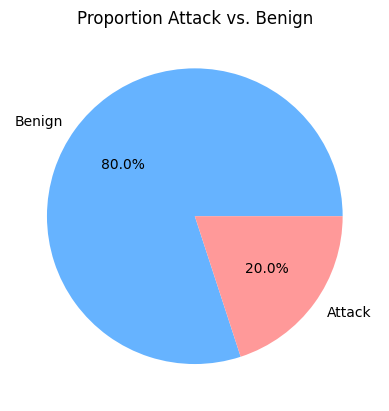

In [10]:
df_all['IsAttack'] = (df_all['Label'] != 'Benign').astype(int)
df_all['IsAttack'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Benign', 'Attack'], colors=['#66b3ff','#ff9999'])
plt.title('Proportion Attack vs. Benign')
plt.ylabel('')
plt.show()

### Now that we see that the vast majority is 'Benign', let's balance the dataset by doing some over and under sampling.

# ML

In [11]:
# Feature/Target
X = df_all.drop('Label', axis=1)
y = df_all['Label']

In [12]:
# Split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.select_dtypes(include=[np.number]).copy()
X_test  = X_test[X_train.columns].copy()

# Downcast for memory
for df in (X_train, X_test):
    for c in df.columns:
        if pd.api.types.is_float_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='float')
        elif pd.api.types.is_integer_dtype(df[c]):
            df[c] = pd.to_numeric(df[c], downcast='integer')


In [13]:
def find_infiltration_label(labels):
    low = [str(c).lower() for c in labels]
    for i, c in enumerate(low):
        if 'infil' in c:  
            return labels[i]
    return None

def build_sampling_strategies(
    y, benign_cap=200_000, infil_label=None, infil_cap=30_000,
    max_per_class=20_000, target_min_smote=8_000, exclude_smote_extra=()
):
    """
    Build RUS/SMOTE strategies valid for the provided y.
    Guarantees RUS <= available samples and sets a minimal target for minority SMOTE.
    """
    counts = Counter(y)

    # RUS caps
    rus = {cls: min(cnt, max_per_class) for cls, cnt in counts.items()}
    if 'Benign' in counts:
        rus['Benign'] = min(counts['Benign'], benign_cap)
    if infil_label and infil_label in counts and infil_cap is not None:
        rus[infil_label] = min(counts[infil_label], infil_cap)
    # Safety: never request more than available
    for cls in list(rus.keys()):
        rus[cls] = min(rus[cls], counts[cls])

    # SMOTE target for small classes (exclude Benign + Infiltration)
    exclude_smote = set(['Benign'])
    if infil_label:
        exclude_smote.add(infil_label)
    exclude_smote |= set(exclude_smote_extra)

    smote = {}
    for cls, cnt_after_rus in rus.items():
        if cls in exclude_smote:
            continue
        if cnt_after_rus >= 2 and cnt_after_rus < target_min_smote:
            smote[cls] = target_min_smote

    # Robust k for SMOTE
    if smote:
        min_after_rus = min(rus[c] for c in smote.keys())
        k = max(1, min(3, min_after_rus - 1))
    else:
        k = 1
    return rus, smote, k

def make_pipeline(rus, smote, k):
    clf = LGBMClassifier(
        objective="multiclass",
        n_estimators=350,
        learning_rate=0.07,
        subsample=0.8,
        colsample_bytree=0.8,
        class_weight="balanced",
        min_child_samples=64,
        force_row_wise=True,
        verbosity=-1,
        random_state=42,
        n_jobs=-1
    )
    steps = [("scale", StandardScaler()),
             ("rus", RandomUnderSampler(sampling_strategy=rus, random_state=42))]
    if smote:
        steps.append(("smote", SMOTE(sampling_strategy=smote, k_neighbors=k, random_state=42)))
    steps.append(("clf", clf))
    return ImbPipeline(steps=steps)

def compute_pi_train(rus, smote, labels):
    counts = pd.Series({c: rus.get(c, 0) for c in labels}, dtype='float64')
    if smote:
        for c, tgt in smote.items():
            counts[c] = tgt
    counts = counts.replace(0, 1.0)
    return (counts / counts.sum()).reindex(labels, fill_value=1e-9)

# Prior correction 
def adjust_proba_by_priors_gamma(proba, labels, pi_true, pi_train, gamma=1.0, eps=1e-12):
    ratio = (pi_true.reindex(labels, fill_value=eps) / pi_train.reindex(labels, fill_value=eps)).values
    ratio = np.power(ratio, float(gamma))
    adj = proba * ratio[None, :]
    adj_sum = adj.sum(axis=1, keepdims=True) + eps
    return adj / adj_sum

# Post-processing: Benign gate + per-class thresholds
def predict_postproc(proba_corr, labels, t_benign=0.5, thresholds=None, fallback_label='Benign'):
    thresholds = thresholds or {}
    lbl = list(labels)
    y_hat = np.array(['__UNK__'] * proba_corr.shape[0], dtype=object)

    idx_benign = lbl.index(fallback_label) if fallback_label in lbl else None
    # Benign gate first
    if idx_benign is not None:
        mask_b = proba_corr[:, idx_benign] >= t_benign
        y_hat[mask_b] = fallback_label
    else:
        mask_b = np.zeros(proba_corr.shape[0], dtype=bool)

    # Thresholded argmax on the rest
    rest = ~mask_b
    sub = proba_corr[rest].copy()
    if thresholds:
        th_vec = np.array([thresholds.get(c, 0.5) for c in lbl], dtype=float)
        sub[sub < th_vec[None, :]] = -1.0
    idx = sub.argmax(axis=1)
    none_ok = (sub.max(axis=1) < 0)
    if idx_benign is not None:
        idx[none_ok] = idx_benign
    y_hat[rest] = np.array(lbl)[idx]
    return y_hat

# Silence LightGBM
try:
    lgb.set_config(verbosity=-1)
except Exception:
    pass

# Split for calibration 
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Infiltration label 
INFIL_TR = find_infiltration_label(sorted(set(y_tr)))

# Sampling strategies adapted to y_tr
rus_tr, smote_tr, k_tr = build_sampling_strategies(
    y_tr, benign_cap=200_000, infil_label=INFIL_TR, infil_cap=30_000,
    max_per_class=20_000, target_min_smote=8_000
)
pipe_cal = make_pipeline(rus_tr, smote_tr, k_tr)
pipe_cal.fit(X_tr, y_tr)
labels_cal = list(pipe_cal.named_steps['clf'].classes_)

# Priors (true vs train) for calibration
pi_true_val = pd.Series(y_tr).value_counts(normalize=True).reindex(labels_cal, fill_value=1e-9)
pi_train_cal = compute_pi_train(rus_tr, smote_tr, labels_cal)
INFIL_LABEL_CAL = find_infiltration_label(labels_cal)

# Personal calibration 
TARGET_REC_B = 0.95            
OPTIMIZE_FOR = "f1_infiltration" 

gamma_grid = [0.0, 0.25, 0.5, 0.75]  # partial prior correction
tB_grid    = np.linspace(0.55, 0.80, 6)
tI_grid    = np.linspace(0.70, 0.88, 10)

def score_combo(y_true, y_pred):
    f1_macro = f1_score(y_true, y_pred, average='macro')
    infil = (y_true == INFIL_LABEL_CAL)
    f1_inf = f1_score(infil, y_pred == INFIL_LABEL_CAL, zero_division=0)
    prec_i = precision_score(infil, y_pred == INFIL_LABEL_CAL, zero_division=0)
    rec_i  = recall_score(infil,  y_pred == INFIL_LABEL_CAL,  zero_division=0)
    rec_b  = recall_score(y_true == 'Benign', y_pred == 'Benign', zero_division=0)
    primary = f1_inf if OPTIMIZE_FOR == "f1_infiltration" else f1_macro
    return primary, f1_macro, f1_inf, prec_i, rec_i, rec_b

best = None
proba_val_raw = pipe_cal.predict_proba(X_val)

for g in gamma_grid:
    pv = adjust_proba_by_priors_gamma(proba_val_raw, labels_cal, pi_true_val, pi_train_cal, gamma=g)
    for tB in tB_grid:
        for tI in tI_grid:
            y_hat = predict_postproc(pv, labels_cal, t_benign=tB,
                                     thresholds={INFIL_LABEL_CAL: tI}, fallback_label='Benign')
            primary, f1_macro, f1_inf, prec_i, rec_i, rec_b = score_combo(y_val, y_hat)
            if rec_b < TARGET_REC_B:  # must keep benign recall high
                continue
            cand = (primary, g, tB, tI, f1_macro, f1_inf, prec_i, rec_i, rec_b)
            if (best is None) or (cand > best):
                best = cand

if best is None:
    raise RuntimeError("No (gamma, tB, tI) combination satisfied the Benign recall constraint. "
                       "Try lowering TARGET_REC_B or widening the grids.")

print("Chosen (validation):",
      f"gamma={best[1]}, t_B={best[2]:.2f}, t_I={best[3]:.2f} |",
      f"macro-F1={best[4]:.3f}, F1_I={best[5]:.3f}, Prec_I={best[6]:.3f}, Rec_I={best[7]:.3f}, Rec_B={best[8]:.3f}")

# Final fit on all X_train,y_train 
INFIL_TRN = find_infiltration_label(sorted(set(y_train)))
rus_trn, smote_trn, k_trn = build_sampling_strategies(
    y_train, benign_cap=200_000, infil_label=INFIL_TRN, infil_cap=30_000,
    max_per_class=20_000, target_min_smote=8_000
)
pipe_final = make_pipeline(rus_trn, smote_trn, k_trn)
pipe_final.fit(X_train, y_train)
labels_final = list(pipe_final.named_steps['clf'].classes_)

# Priors for test-time correction
pi_true_train  = pd.Series(y_train).value_counts(normalize=True).reindex(labels_final, fill_value=1e-9)
pi_train_final = compute_pi_train(rus_trn, smote_trn, labels_final)

# Test evaluation: post-processed vs raw argmax 
proba_test = pipe_final.predict_proba(X_test)
proba_test_corr = adjust_proba_by_priors_gamma(
    proba_test, labels_final, pi_true_train, pi_train_final, gamma=best[1]
)

y_pred_pp = predict_postproc(
    proba_test_corr, labels_final, t_benign=best[2],
    thresholds={find_infiltration_label(labels_final): best[3]}, fallback_label='Benign'
)

print("\n=== TEST report (personal mode: gamma+t_B+t_I) ===")
print(classification_report(y_test, y_pred_pp, digits=3))

y_pred_raw = pipe_final.predict(X_test)
print("\n=== TEST report (raw argmax) ===")
print(classification_report(y_test, y_pred_raw, digits=3))
print("Confusion matrix (raw argmax):\n", confusion_matrix(y_test, y_pred_raw))

# For later saving/visualization
CALIBRATION_CHOICE = {
    "gamma": float(best[1]),
    "t_benign": float(best[2]),
    "t_infiltration": float(best[3]),
    "optimize_for": OPTIMIZE_FOR
}


Chosen (validation): gamma=0.75, t_B=0.80, t_I=0.74 | macro-F1=0.835, F1_I=0.999, Prec_I=0.999, Rec_I=0.999, Rec_B=1.000

=== TEST report (personal mode: gamma+t_B+t_I) ===
                          precision    recall  f1-score   support

                  Benign      1.000     1.000     1.000   1065802
                     Bot      1.000     0.999     0.999     28907
        Brute Force -Web      0.930     0.938     0.934       113
        Brute Force -XSS      0.772     0.957     0.854        46
        DDOS attack-HOIC      1.000     1.000     1.000     39772
    DDOS attack-LOIC-UDP      0.758     0.994     0.860       346
  DDoS attacks-LOIC-HTTP      1.000     0.999     0.999    115073
   DoS attacks-GoldenEye      1.000     1.000     1.000      8281
        DoS attacks-Hulk      1.000     1.000     1.000     29040
DoS attacks-SlowHTTPTest      0.250     0.273     0.261        11
   DoS attacks-Slowloris      0.989     0.998     0.994      1982
          FTP-BruteForce      0.20

In [14]:
import joblib, json
from datetime import datetime

ARTIFACT_BUNDLE = {
    "pipe": pipe_final,
    "feature_names": list(X_train.columns),
    "labels": labels_final,
    "priors_true": pi_true_train.to_dict(),     
    "priors_train": pi_train_final.to_dict(),
    "calibration": CALIBRATION_CHOICE          # gamma, thresholds, objective
}

joblib.dump(ARTIFACT_BUNDLE, "cyber_idia_bundle.joblib")

CONFIG = {
    "created_at": datetime.utcnow().isoformat() + "Z",
    "notes": "IDS2018 personal project; numeric-only features; memory-safe rebalancing; "
             "post-processing with partial prior correction + thresholds.",
    "gamma": CALIBRATION_CHOICE["gamma"],
    "t_benign": CALIBRATION_CHOICE["t_benign"],
    "t_infiltration": CALIBRATION_CHOICE["t_infiltration"],
    "labels": labels_final,
    "feature_count": len(X_train.columns)
}
with open("cyber_idia_config.json", "w") as f:
    json.dump(CONFIG, f, indent=2)

print("Saved: cyber_idia_bundle.joblib, cyber_idia_config.json")


Saved: cyber_idia_bundle.joblib, cyber_idia_config.json


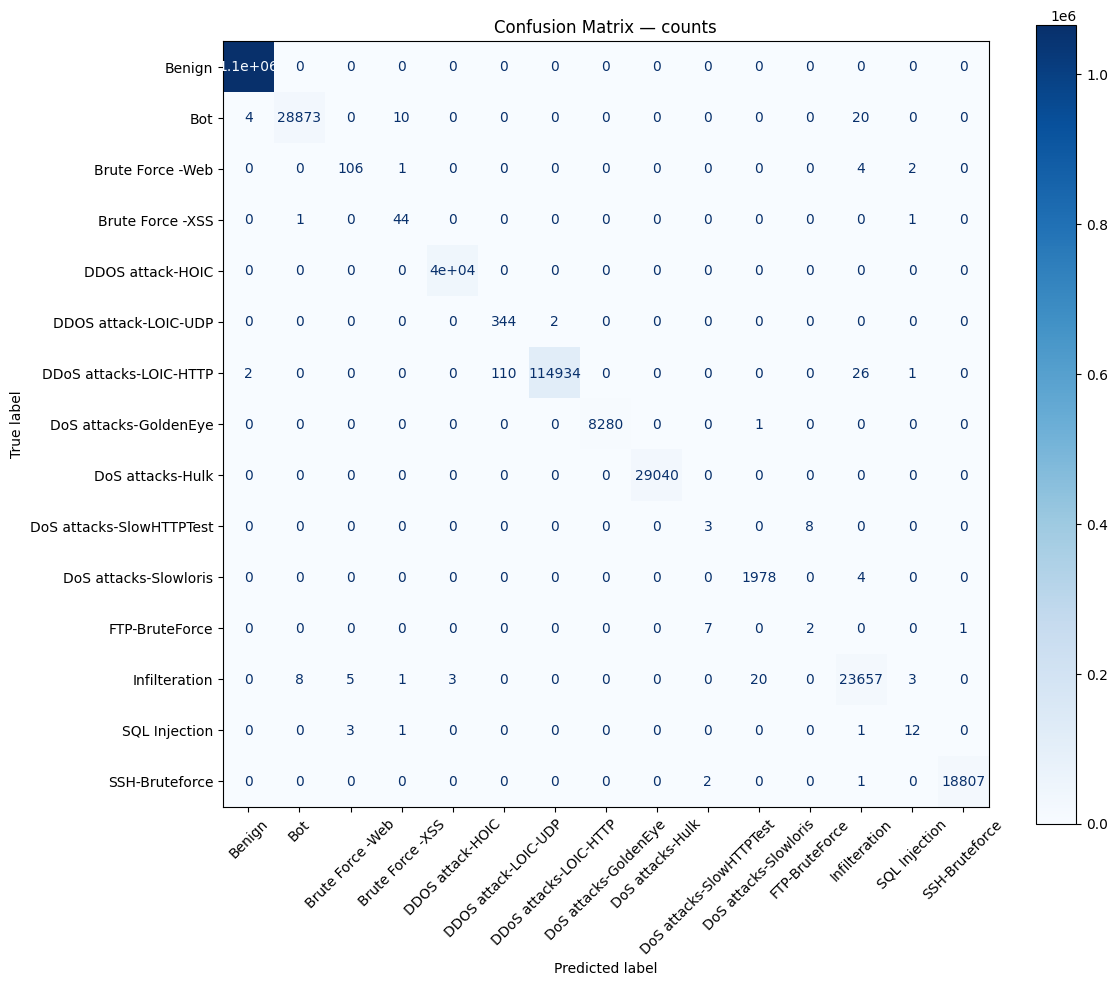

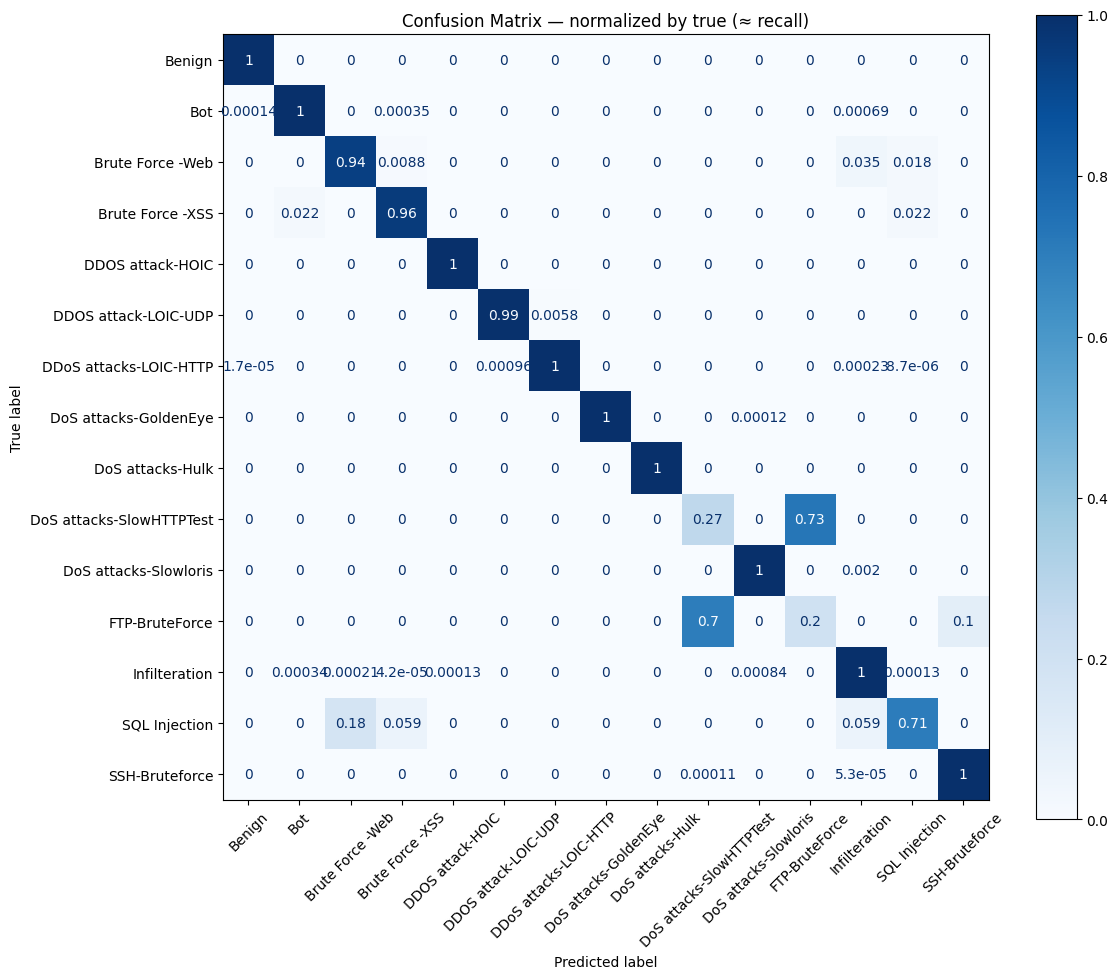

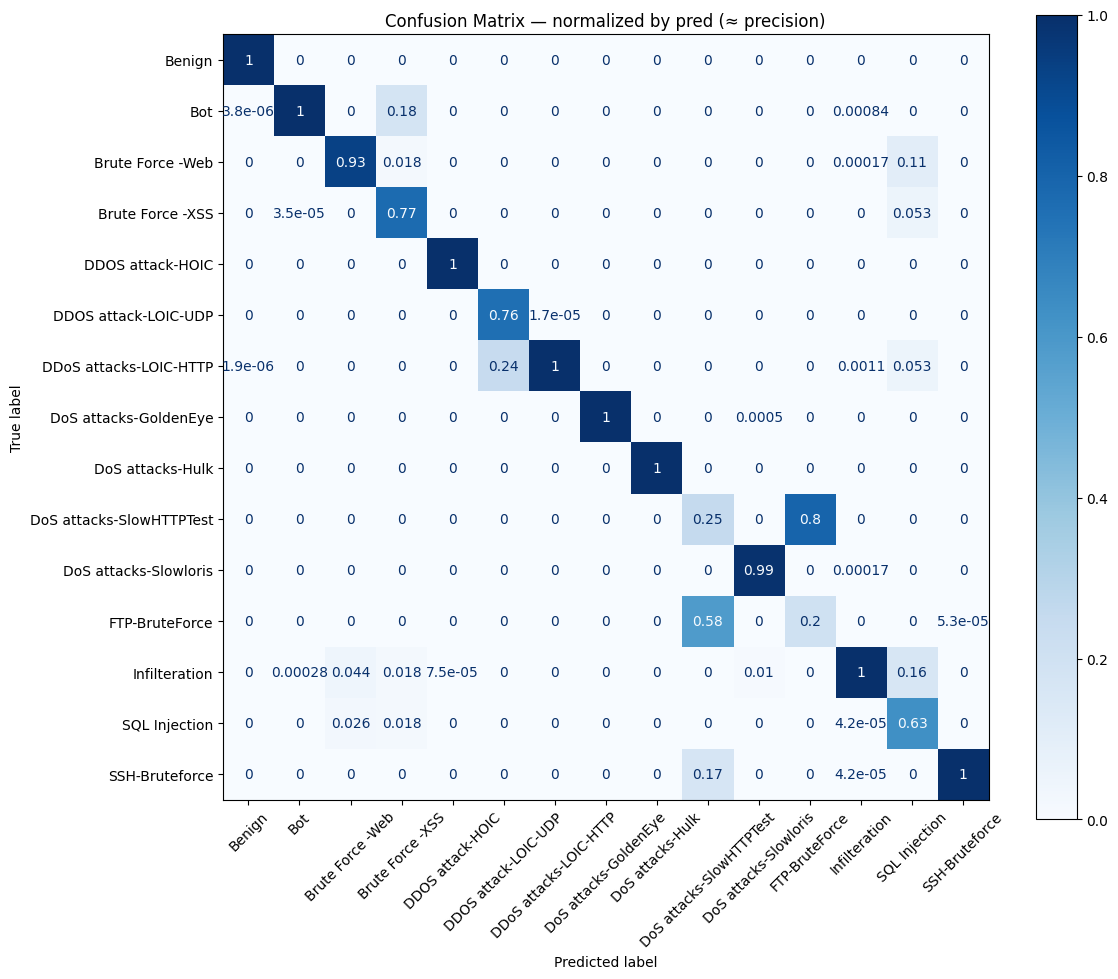

Top off-diagonal confusions:
DDoS attacks-LOIC-HTTP → DDOS attack-LOIC-UDP : 110
DDoS attacks-LOIC-HTTP → Infilteration : 26
Infilteration → DoS attacks-Slowloris : 20
Bot → Infilteration : 20
Bot → Brute Force -XSS : 10
DoS attacks-SlowHTTPTest → FTP-BruteForce : 8
Infilteration → Bot : 8
FTP-BruteForce → DoS attacks-SlowHTTPTest : 7
Infilteration → Brute Force -Web : 5
DoS attacks-Slowloris → Infilteration : 4


In [15]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.utils.multiclass import unique_labels

#y_pred_vis = y_pred_raw
y_pred_vis = y_pred_pp   

labels_vis = unique_labels(y_test, y_pred_vis)

# Counts
fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_vis,
    labels=labels_vis,
    normalize=None,
    cmap='Blues',
    xticks_rotation=45,
    ax=ax
)
ax.set_title('Confusion Matrix — counts')
plt.tight_layout()
plt.show()

# Normalized by true (row-wise): approximates per-class recall
fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_vis,
    labels=labels_vis,
    normalize='true',
    cmap='Blues',
    xticks_rotation=45,
    ax=ax
)
ax.set_title('Confusion Matrix — normalized by true (≈ recall)')
plt.tight_layout()
plt.show()

# Normalized by pred (column-wise): approximates per-class precision
fig, ax = plt.subplots(figsize=(12,10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_vis,
    labels=labels_vis,
    normalize='pred',
    cmap='Blues',
    xticks_rotation=45,
    ax=ax
)
ax.set_title('Confusion Matrix — normalized by pred (≈ precision)')
plt.tight_layout()
plt.show()

# Top off-diagonal confusions (useful to explain errors)
cm = confusion_matrix(y_test, y_pred_vis, labels=labels_vis)
err = cm.copy()
np.fill_diagonal(err, 0)
pairs = np.dstack(np.unravel_index(np.argsort(err.ravel())[::-1], err.shape))[0]

print("Top off-diagonal confusions:")
for i in range(min(10, len(pairs))):
    r, c = pairs[i]
    if err[r, c] == 0:
        break
    print(f"{labels_vis[r]} → {labels_vis[c]} : {err[r, c]}")


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

def plot_per_class_metrics(y_true, y_pred, labels=None, filename="per_class_metrics.png"):
    """
    Grouped bars: Precision / Recall / F1 for each class.
    Saves a 1600x900 PNG suitable for LinkedIn.
    """
    if labels is None:
        labels = np.unique(np.concatenate([np.array(y_true), np.array(y_pred)]))

    prec, rec, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    x = np.arange(len(labels), dtype=float)
    width = 0.25

    plt.figure(figsize=(16,9), dpi=150)
    plt.bar(x - width, prec,  width, label="Precision")
    plt.bar(x,          rec,  width, label="Recall")
    plt.bar(x + width,  f1,   width, label="F1")

    plt.xticks(x, labels, rotation=45, ha="right", fontsize=11)
    plt.yticks(np.linspace(0, 1, 6))
    plt.ylim(0, 1.05)
    plt.grid(axis="y", alpha=0.3)
    plt.title("Per-class Precision / Recall / F1", fontsize=18, weight="bold")
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=200, bbox_inches="tight")
    plt.close()


plot_per_class_metrics(y_test, y_pred_pp, labels=pipe_final.named_steps["clf"].classes_)
